In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
import cv2
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.models import Sequential, Model
import os
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def create_dir(x):
    if not os.path.exists(x):
        os.makedirs(x)

save_path = "/kaggle/input/vegetation-aerial-images-1024/augmented1024"

# augment_data(images, masks, save_path, augment=True)

images = sorted(glob(os.path.join(save_path, "images/*")))
masks = sorted(glob(os.path.join(save_path, "masks/*")))
print(f"Total images:  {len(images)} - Total masks: {len(masks)}")

Total images:  924 - Total masks: 924


In [3]:
## Create dataframe

image_path =  os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

def create_dataframe(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))
#print(df_images)

Total Images:  924


In [4]:
## Split data

X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19) #split 10% data from dataset to create test data
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19) #split 20% data from remaining data to create validation data

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(image_path, f"{name}.JPG") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(image_path, f"{name}.JPG") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(image_path, f"{name}.JPG") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

Train Size : 664 images
Val Size   :  167 images
Test Size  :  93 images


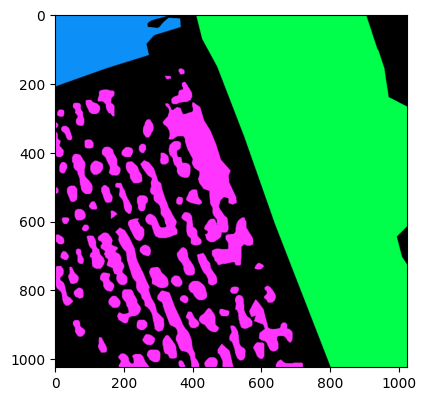

[[3 3 3 3 0 3 0 1 1 1 1 1 1 1 0 0]
 [3 3 3 3 0 0 0 1 1 1 1 1 1 1 1 0]
 [3 3 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
 [0 0 2 0 0 0 0 0 1 1 1 1 1 1 1 0]
 [0 0 1 0 0 2 2 0 1 1 1 1 1 1 1 1]
 [2 0 0 0 0 2 2 0 0 1 1 1 1 1 1 1]
 [0 0 2 0 0 2 2 0 0 1 1 1 1 1 1 1]
 [0 1 0 2 2 0 1 2 0 1 1 1 1 1 1 1]
 [0 0 2 0 0 1 2 0 0 0 1 1 1 1 1 1]
 [1 0 0 2 2 1 0 2 2 0 1 1 1 1 1 1]
 [0 0 2 2 0 0 0 0 1 0 1 1 1 1 1 1]
 [0 0 0 2 2 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 2 0 0 0 2 0 0 0 0 1 1 1 1 1]
 [0 0 0 2 2 2 0 2 2 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 2 2 0 1 1 1 1]
 [0 0 0 0 2 2 0 1 2 0 0 0 1 1 1 1]]


In [5]:
import random as rnd
import cv2
from pylab import *

n = rnd.randint(0, len(img_train))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
y = cv2.imread(mask_train[n])
y2 = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
imshow(y2)
plt.show()

x = cv2.imread(mask_train[n], cv2.IMREAD_GRAYSCALE)
x[x == 158] = 1 
x[x == 135] = 2 
x[x == 116] = 3
x[x > 3] = 0
x = cv2.resize(x, (16, 16))
print(x) 

In [6]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)

    return x

def build_mobilenetv2_unet(input_shape):    ## (512, 512, 3)
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs, alpha=1.0)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output                ## (512 x 512)
    s2 = encoder.get_layer("block_1_expand_relu").output    ## (256 x 256)
    s3 = encoder.get_layer("block_3_expand_relu").output    ## (128 x 128)
    s4 = encoder.get_layer("block_6_expand_relu").output    ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output   ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 128)                         ## (64 x 64)
    d2 = decoder_block(d1, s3, 64)                         ## (128 x 128)
    d3 = decoder_block(d2, s2, 32)                         ## (256 x 256)
    d4 = decoder_block(d3, s1, 16)                          ## (512 x 512)

    """ Output """
    outputs = Conv2D(4, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net")
    return model

In [7]:
## Define the resolution of the images and the number of classes

H = 1024   
W = 1024 
num_classes = 4
#calling function to build model
# model = build_mobilenetv2_unet((H, W, 3)) 
## Show the summary of the U-Net model and its diagram

# model.summary()
# print("Total number of layers : ", len(model.layers))
# plot_model(model,to_file='model.png') #plot flow diagram

In [8]:
## Dataset Pipeline used for training the model

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x[x == 158] = 1 
    x[x == 135] = 2 
    x[x == 116] = 3
    x[x > 3] = 0
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

**Train Model:**

In [9]:
## Train the model

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
shape = (H, W, 3) 
num_classes = 4  # number of classes in image
lr = 1e-4 #learning rate 
batch_size = 4 #entire dataset is divided into batches 
epochs = 50 #when  entire dataset is passed through architecture its 1 epoch

# Model
model = build_mobilenetv2_unet(shape)

#compiling model | loss = loss detection function, optimizer = optimizer for updating filters
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy']) 

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size) #creating training dataset
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size) #creating validation dataset

train_steps = len(img_train)//batch_size  #training steps is also called iteration
valid_steps = len(img_val)//batch_size # vaidation steps

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True), #save model with best accuracy
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1, min_lr=1e-6), #reduce learning rate if loss doesn't decrease after 3 epochs
    EarlyStopping(monitor='val_loss', patience=10, verbose=1) #stop training if loss doesn't decrease after 5 epochs
]

#model.fit function is used to train model
model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks
         )

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
166/166 [==============================] - ETA: 0s - loss: 1.0693 - accuracy: 0.6260
Epoch 1: saving model to model.h5
166/166 [==============================] - 129s 566ms/step - loss: 1.0693 - accuracy: 0.6260 - val_loss: 0.9765 - val_accuracy: 0.6784 - lr: 1.0000e-04
Epoch 2/50
166/166 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.8409
Epoch 2: saving model to model.h5
166/166 [==============================] - 84s 505ms/step - loss: 0.7150 - accuracy: 0.8409 - val_loss: 1.0516 - val_accuracy: 0.6025 - lr: 1.0000e-04
Epoch 3/50
166/166 [==============================] - ETA: 0s - loss: 0.5976 - accuracy: 0.8811
Epoch 3: saving model to model.h5
166/166 [==============================] - 93s 560ms/step - loss: 0.5976 - accuracy: 0.8811 - val_loss: 1.0117 - val_accuracy: 0.6157 - lr: 1.0000e-04
Epoch 4/50
166/166 [==============================] - ETA: 0s - loss: 0.5181 - accuracy: 0.89

In [10]:
model.save('aerial-mobilenetv2.h5')

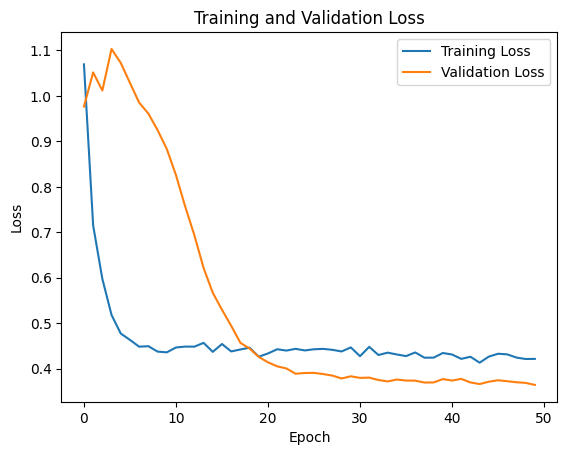

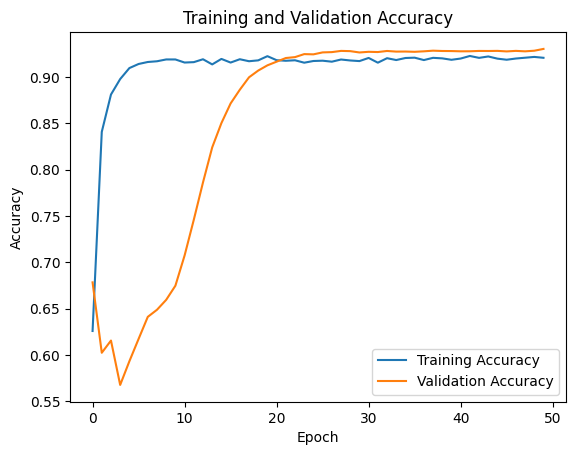

In [11]:
# plot the training loss
plt.plot(model.history.history['loss'], label='Training Loss')

# plot the validation loss if available
if 'val_loss' in model.history.history:
    plt.plot(model.history.history['val_loss'], label='Validation Loss')

# set the axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# display the legend
plt.legend()

# save the plot as EPS and PNG file
plt.savefig('loss_aerial-mobilenetv2.eps', format='eps', dpi=1200)
plt.savefig('loss_aerial-mobilenetv2.png', dpi=1200)

# show the plot
plt.show()

# plot the training accuracy
plt.plot(model.history.history['accuracy'], label='Training Accuracy')

# plot the validation accuracy if available
if 'val_accuracy' in model.history.history:
    plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')

# set the axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# display the legend
plt.legend()

# save the plot as EPS and PNG file
plt.savefig('accuracy_aerial-mobilenetv2.eps', format='eps', dpi=1200)
plt.savefig('accuracy_aerial-mobilenetv2.png', dpi=1200)

# show the plot
plt.show()


In [12]:
import imghdr
create_dir('/kaggle/working/output')
create_dir('/kaggle/working/prediction')
create_dir('/kaggle/working/img_test')
create_dir('/kaggle/working/mask_test')

# Define the paths to the model file
model_path = "/kaggle/working/model.h5"

# Define the image size and number of classes
img_size = (1024, 1024)
num_classes = 4  # 2 objects + background

# Load the model
model = tf.keras.models.load_model(model_path)

In [13]:
# Save Test Data to seperate folders
import os
import shutil

# Path of the source folder containing files to copy
source_folder_path = "/kaggle/input/vegetation-aerial-images-1024/augmented1024/images"
source_folder_path2 = "/kaggle/input/vegetation-aerial-images-1024/augmented1024/masks"
# Path of the destination folder where files will be copied
destination_folder_path = "/kaggle/working/img_test"
destination_folder_path2 = "/kaggle/working/mask_test"

# List of filenames to copy
filenames_to_copy = [os.path.basename(file_path) for file_path in img_test] #test images
filenames_to_copy2 = [os.path.basename(file_path) for file_path in mask_test] #test masks

# Iterate through all the files in the source folder
for filename in os.listdir(source_folder_path):
    # Check if the file is in the filenames to copy list
    if filename in filenames_to_copy:
        # If it is, construct the paths to the source and destination files
        source_file_path = os.path.join(source_folder_path, filename)
        destination_file_path = os.path.join(destination_folder_path, filename)
        # Copy the file to the destination folder
        shutil.copyfile(source_file_path, destination_file_path)
#         print(f"File {filename} has been copied to the destination folder.")
        
for filename in os.listdir(source_folder_path2):
    # Check if the file is in the filenames to copy list
    if filename in filenames_to_copy2:
        # If it is, construct the paths to the source and destination files
        source_file_path = os.path.join(source_folder_path2, filename)
        destination_file_path = os.path.join(destination_folder_path2, filename)
        # Copy the file to the destination folder
        shutil.copyfile(source_file_path, destination_file_path)
        print(f"File {filename} has been copied to the destination folder.")


File 0150_3.png has been copied to the destination folder.
File 0216_0.png has been copied to the destination folder.
File 0262_1.png has been copied to the destination folder.
File 0136_0.png has been copied to the destination folder.
File 0226_3.png has been copied to the destination folder.
File 0248_3.png has been copied to the destination folder.
File 0214_5.png has been copied to the destination folder.
File 0117_3.png has been copied to the destination folder.
File 0143_1.png has been copied to the destination folder.
File 0138_1.png has been copied to the destination folder.
File 0172_0.png has been copied to the destination folder.
File 0247_2.png has been copied to the destination folder.
File 0169_5.png has been copied to the destination folder.
File 0167_3.png has been copied to the destination folder.
File 0144_0.png has been copied to the destination folder.
File 0155_4.png has been copied to the destination folder.
File 0003_5.png has been copied to the destination folde

In [14]:
# prediction in test data
# Define the input and output directory to save the predicted masks
output_dir = "/kaggle/working/output"
input_dir = "/kaggle/working/img_test"

# Loop through each input image in the input directory
for filename in os.listdir(input_dir):
    # Load the input image and preprocess it
    img = cv2.imread(os.path.join(input_dir, filename))
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Perform prediction using the loaded model
    pred = model.predict(img)[0]
    pred = np.argmax(pred, axis=-1)

    # Save the predicted mask to the output directory
    mask = np.zeros((img_size[0], img_size[1], 3), dtype=np.int32)
    mask[pred == 0] = [0, 0, 0]  # Background
    mask[pred == 1] = [0, 255, 75]  # Object 1 (BGR)
    mask[pred == 2] = [255, 52, 255]  # Object 2 
    mask[pred == 3] = [248, 144, 12]  # Object 2 
    output_filename = os.path.join(output_dir, os.path.splitext(filename)[0] + ".png")
    cv2.imwrite(output_filename, mask)


1/1 [==============================] - 0s 30ms/step


In [15]:
# Concatenate Image, Mask and Prediction
# Define the paths to the predicted, ground truth, and input image directories
pred_dir = "/kaggle/working/output"
gt_dir = "/kaggle/working/mask_test"
input_dir = "/kaggle/working/img_test"

# Define the output directory to save the concatenated images
output_dir = "/kaggle/working/prediction"

# Define the border color and width
border_color = (255, 255, 255)  # white
border_width = 5

# Loop through each input image in the input image directory
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)

    # Extract the filename without extension
    file_prefix = os.path.splitext(filename)[0]

    # Construct the paths to the predicted and ground truth images
    pred_path = os.path.join(pred_dir, file_prefix + ".png")
    gt_path = os.path.join(gt_dir, file_prefix + ".png")

    # Load the predicted, ground truth, and input images
    pred_img = cv2.imread(pred_path, cv2.IMREAD_UNCHANGED)
    pred_img = cv2.resize(pred_img, (1024, 1024))
    gt_img = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
    input_img = cv2.imread(input_path)

    # Check that all images have nonzero dimensions
    if pred_img.size == 0 or gt_img.size == 0 or input_img.size == 0:
        print(f"Skipping {filename} due to zero-dimensional array")
        continue

    # Create a blank border image and concatenate it with the images
    border_img = np.ones((input_img.shape[0], border_width, 3), dtype=np.uint8) * border_color
    concat_img = np.concatenate((input_img, border_img, gt_img, border_img, pred_img), axis=1)

    # Save the concatenated image to the output directory
    output_filename = os.path.join(output_dir, filename)
    cv2.imwrite(output_filename, concat_img)

In [18]:
!zip -r /kaggle/working/aerial-mobilnetv2.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/prediction/ (stored 0%)
  adding: kaggle/working/prediction/0118_0.JPG (deflated 4%)
  adding: kaggle/working/prediction/0239_2.JPG (deflated 4%)
  adding: kaggle/working/prediction/0150_5.JPG (deflated 7%)
  adding: kaggle/working/prediction/0148_3.JPG (deflated 4%)
  adding: kaggle/working/prediction/0157_2.JPG (deflated 4%)
  adding: kaggle/working/prediction/0175_0.JPG (deflated 7%)
  adding: kaggle/working/prediction/0143_1.JPG (deflated 4%)
  adding: kaggle/working/prediction/0202_5.JPG (deflated 3%)
  adding: kaggle/working/prediction/0260_1.JPG (deflated 7%)
  adding: kaggle/working/prediction/0246_4.JPG (deflated 5%)
  adding: kaggle/working/prediction/0024_3.JPG (deflated 5%)
  adding: kaggle/working/prediction/0011_5.JPG (deflated 6%)
  adding: kaggle/working/prediction/0145_4.JPG (deflated 5%)
  adding: kaggle/working/prediction/0255_2.JPG (deflated 5%)
  adding: kaggle/working/prediction/0167_3.JPG (deflated 9%

In [17]:
# !rm -rf /kaggle/working/aerial-unet2-accu.eps